Elaboration of data output from SQL database

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import re
import numpy as np

In [2]:
# Importing from esm database.db
conn = sqlite3.connect('database.db')
query_cost_op_tot = "SELECT * FROM cost_op_tot"  
cost_op_tot = pd.read_sql_query(query_cost_op_tot, conn)
query_cost_period = "SELECT * FROM cost_period"
cost_period = pd.read_sql_query(query_cost_period, conn)
query_active_techs = "SELECT * FROM active_techs"
active_techs = pd.read_sql_query(query_active_techs, conn)
query_cost_cap = "SELECT * FROM cost_cap"
cost_cap= pd.read_sql_query(query_cost_cap, conn)
query_cap_tot = "SELECT * FROM cap_tot"
cap_tot= pd.read_sql_query(query_cap_tot, conn)
query_cost_inv = "SELECT * FROM cost_inv"
cost_inv= pd.read_sql_query(query_cost_inv, conn)
query_new_units= "SELECT * FROM new_units"
new_units= pd.read_sql_query(query_new_units, conn)

#For scalar values
query_disc_frac = "SELECT * FROM disc_frac"
disc_frac_pd= pd.read_sql_query(query_disc_frac, conn)
disc_frac=disc_frac_pd['values'].iloc[0]
query_insulation = "SELECT * FROM insulation"
insulation_pd= pd.read_sql_query(query_insulation, conn)
insulation=insulation_pd['values'].iloc[0]
query_TI_cost = "SELECT * FROM TI_cost"
TI_cost_pd= pd.read_sql_query(query_TI_cost, conn)
TI_cost=TI_cost_pd['values'].iloc[0]

conn.close()

In [3]:
activity_costs=sum(cost_op_tot['values'])
periodic_costs=sum(cost_period['values']*active_techs['values'])+sum(cost_cap['values']*cap_tot['values'])
bill_one_year=activity_costs+periodic_costs
discount=sum(disc_frac ** x for x in range(1, 11))
operation_costs_discounted=bill_one_year*discount
investment_costs=sum(cost_inv['values']*new_units['values'])
NPC=operation_costs_discounted+investment_costs

print('The NPC is over 10 years is: ', round(NPC,2),'€')
print('For each year the operative expenses are:', round(bill_one_year,2), '€')
print('The initial investment cost is:', round(investment_costs,2),'€')


The NPC is over 10 years is:  7562.78 €
For each year the operative expenses are: 638.23 €
The initial investment cost is: 2450.0 €


In [6]:
investment_cost_breakdown=pd.DataFrame()
investment_cost_breakdown['t_names']=cost_inv['t_names']
investment_cost_breakdown['values']=cost_inv['values']*new_units['values']
print('Technology expansion investment:\n', investment_cost_breakdown[investment_cost_breakdown['values']!=0])

Technology expansion investment:
            t_names  values
3               HP  2000.0
4       Storage HW   200.0
6  Induction stove   250.0


Graphs

In [7]:
# Importing from esm database.db
conn = sqlite3.connect('database.db')
query_Y = "SELECT * FROM Y"  
Y = pd.read_sql_query(query_Y, conn)
query_Q = "SELECT * FROM Q"
Q = pd.read_sql_query(query_Q, conn)
query_X = "SELECT * FROM X"
X = pd.read_sql_query(query_X, conn)
query_Xt = "SELECT * FROM X_t"
Xt = pd.read_sql_query(query_Xt, conn)

conn.close()

In [8]:
seasons = ['wi', 'mc', 'mw', 'su']
season_names = {'wi': 'Winter', 'mc': 'Mid-cold', 'mw': 'Mid-warm', 'su': 'Summer'}

In [9]:
#Isolate peak hour
peak_Y= Y[Y['th_names'] == 'h_peak']
Y=Y[Y['th_names'] != 'h_peak']
peak_Q= Q[Q['th_names'] == 'h_peak']
Q=Q[Q['th_names'] != 'h_peak']
peak_X=X[X['th_names'] == 'h_peak']
X=X[X['th_names'] != 'h_peak']
peak_Xt=Xt[Xt['th_names'] == 'h_peak']
Xt=Xt[Xt['th_names'] != 'h_peak']

In [10]:
#Temporal features
for db in [Y,Q,X,Xt]:
    db.loc[:,'season']=db['th_names'].str[4:6]
    db['hour'] = db['th_names'].str[1:3].astype(int)
    db['day'] = db['th_names'].str[-2:].astype(int)
    db['time'] = (db['day'] - 1) * 24 + db['hour']

In [11]:
PV_prod=X[X['a_names']=='PV']
PV_sell=X[X['a_names']=='National Grid export']
Battery=X[X['a_names']=='Storing EE']
Batt_charge=Battery.copy()
Batt_charge['values'] = Batt_charge['values'].apply(lambda x: 0 if x > 0 else x)
PV_consump=PV_prod.copy()
PV_consump['values']=PV_prod['values'].to_numpy()-PV_sell['values'].to_numpy()+Batt_charge['values'].to_numpy()

Batt_discharge=Battery.copy()
Batt_discharge['values'] = Batt_discharge['values'].to_numpy()-PV_sell['values'].to_numpy()
Batt_discharge['values'] = Batt_discharge['values'].apply(lambda x: 0 if x < 0 else x)

EE_grid=X[X['a_names']=='National Grid import']

In [15]:
Y_summer=Y[Y['season']=='su']
Y_summer.to_excel('excel database/Y_summer.xlsx')
Q_summer=Q[Q['season']=='su']
Q_summer.to_excel('excel database/Q_summer.xlsx')
X_summer=X[X['season']=='su']
X_summer.to_excel('excel database/X_summer.xlsx')


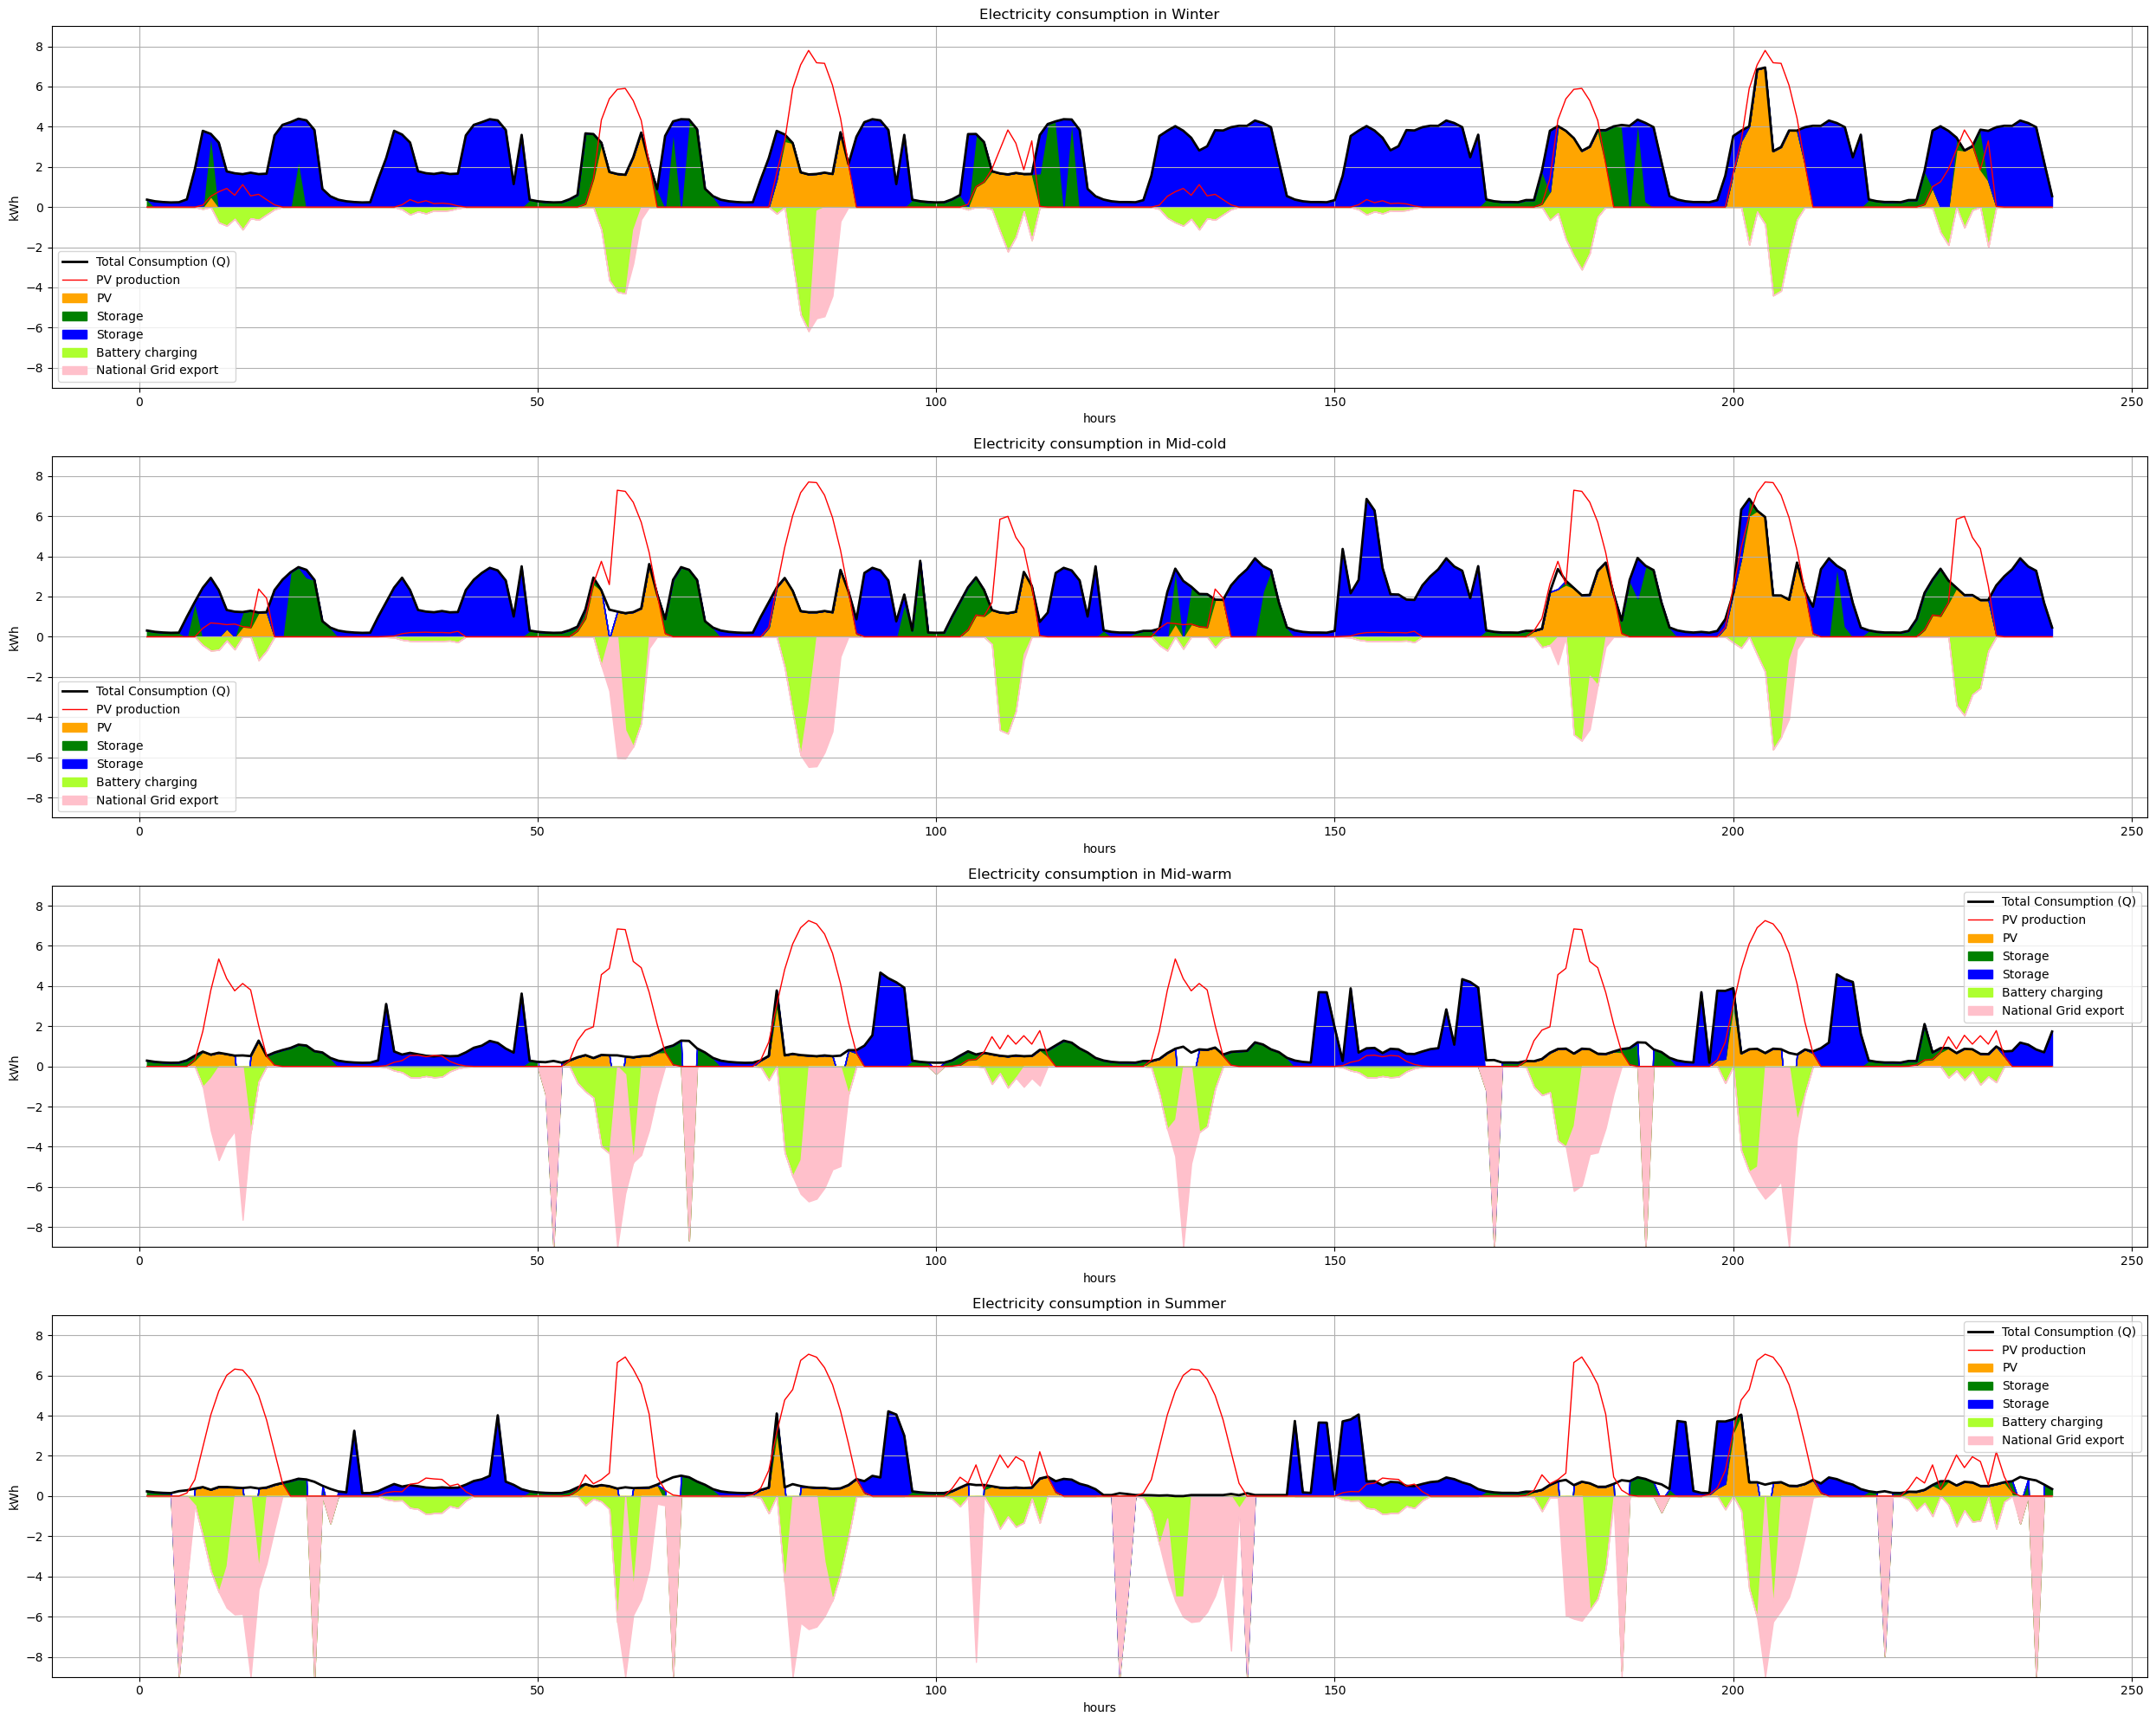

In [12]:
#Electricity production
plt.figure(figsize=(25, 20))
Time=range(1,241)
Time_ind=pd.Index(range(1, 241))
for i, season in enumerate(seasons, 1):
    Q_season = Q[(Q['season'] == season) & (Q['n_names'] == 'EE')]['values']
    PV_prod_season = PV_prod[PV_prod['season'] == season]['values']
    PV_consump_season = PV_consump[PV_consump['season'] == season]['values']
    PV_consump_season.index=Time_ind
    Batt_discharge_season = Batt_discharge[Batt_discharge['season'] == season]['values']
    Batt_discharge_season.index=Time_ind
    EE_grid_season = EE_grid[EE_grid['season'] == season]['values']
    EE_grid_season.index=Time_ind

    Batt_charge_season = Batt_charge[Batt_charge['season'] == season]['values']
    Batt_charge_season.index=Time_ind
    PV_sell_season=-PV_sell[PV_sell['season'] == season]['values']
    PV_sell_season.index=Time_ind

    plt.subplot(4, 1, i)
    plt.plot(Time, Q_season, color='black', linewidth=2, label='Total Consumption (Q)')
    plt.plot(Time, PV_prod_season, color='red', linewidth=1, label='PV production')
    plt.fill_between(Time,0,PV_consump_season, color='orange', label='PV')
    plt.fill_between(Time,PV_consump_season,PV_consump_season+Batt_discharge_season, color='green', label='Storage')
    plt.fill_between(Time,PV_consump_season+Batt_discharge_season,PV_consump_season+Batt_discharge_season+EE_grid_season, color='blue', label='Storage')
    #negative
    plt.fill_between(Time,0,Batt_charge_season, color='greenyellow', label='Battery charging')
    plt.fill_between(Time,Batt_charge_season,Batt_charge_season+PV_sell_season, color='pink', label='National Grid export')
    plt.xlabel('hours')
    plt.ylabel('kWh')
    plt.ylim(-9,9)
    plt.title(f'Electricity consumption in {season_names[season]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

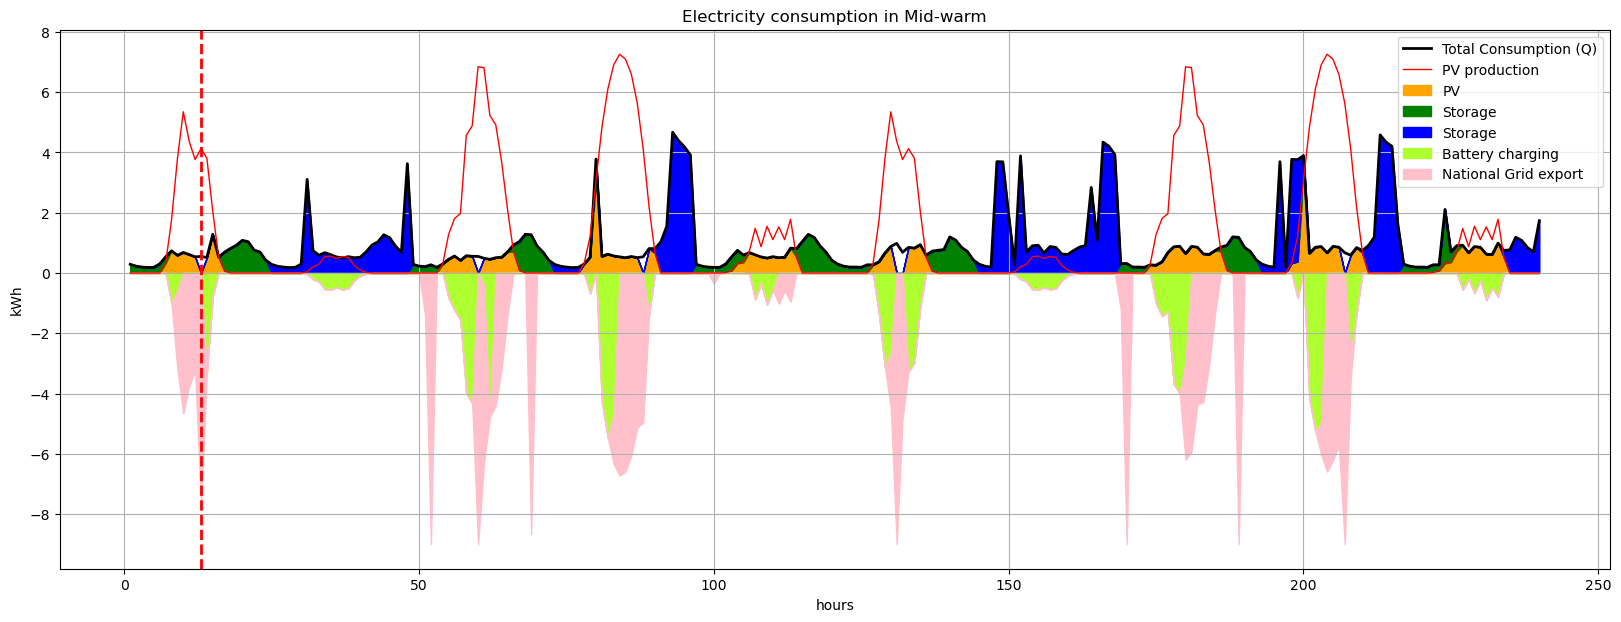

In [152]:
#Electricity production
plt.figure(figsize=(20, 7))
Time=range(1,241)
Time_ind=pd.Index(range(1, 241))
season='mw'
Q_season = Q[(Q['season'] == season) & (Q['n_names'] == 'EE')]['values']
PV_prod_season = PV_prod[PV_prod['season'] == season]['values']
PV_consump_season = PV_consump[PV_consump['season'] == season]['values']
PV_consump_season.index=Time_ind
Batt_discharge_season = Batt_discharge[Batt_discharge['season'] == season]['values']
Batt_discharge_season.index=Time_ind
EE_grid_season = EE_grid[EE_grid['season'] == season]['values']
EE_grid_season.index=Time_ind

Batt_charge_season = Batt_charge[Batt_charge['season'] == season]['values']
Batt_charge_season.index=Time_ind
PV_sell_season=-PV_sell[PV_sell['season'] == season]['values']
PV_sell_season.index=Time_ind

plt.plot(Time, Q_season, color='black', linewidth=2, label='Total Consumption (Q)')
plt.plot(Time, PV_prod_season, color='red', linewidth=1, label='PV production')
plt.fill_between(Time,0,PV_consump_season, color='orange', label='PV')
plt.fill_between(Time,PV_consump_season,PV_consump_season+Batt_discharge_season, color='green', label='Storage')
plt.fill_between(Time,PV_consump_season+Batt_discharge_season,PV_consump_season+Batt_discharge_season+EE_grid_season, color='blue', label='Storage')
#negative
plt.fill_between(Time,0,Batt_charge_season, color='greenyellow', label='Battery charging')
plt.fill_between(Time,Batt_charge_season,Batt_charge_season+PV_sell_season, color='pink', label='National Grid export')
plt.xlabel('hours')
plt.ylabel('kWh')
plt.title(f'Electricity consumption in {season_names[season]}')
plt.legend()
plt.grid(True)
plt.axvline(x=13, color='red', linestyle='--', linewidth=2, label='Event 1')

plt.show()